<a href="https://colab.research.google.com/github/alfred-mg/Image-Classification/blob/main/road2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Model for Road Condition Detection


To do this, we'll perform the following steps:

* **Data Preparation:**

Load the training and validation data using ImageDataGenerator or tf.keras.utils.image_dataset_from_directory, apply data augmentation to improve model generalization, and normalize the pixel values.

* **Model Architecture:**

Design a deep learning model with advanced techniques such as deeper architectures, residual connections, batch normalization, etc.

* **Hyperparameter Tuning:**

Experiment with different learning rates, batch sizes, optimizers, dropout rates, etc., to find the best combination for the model.

* **Training:**

rain the model on the training data using the chosen hyperparameters.

* **Evaluation:**

Evaluate the model on the held-out validation set and report performance metrics like accuracy, precision, recall, and F1-score.

Let's proceed with implementing the above steps in the code. We'll use TensorFlow and Keras for this task.

In [1]:
!pip install tensorflow
!pip install gdown

In [2]:
import os
import gdown
import torch
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, SeparableConv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dropout, add

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ModuleNotFoundError: No module named 'tensorflow.python.platform'

## Loading Datasets and Preparations

### Define data paths

The folders were saved according to the labels. Both the good road photos were saved in folders called 1 and the bad road photos were saved in folders called 0. Then Training good and bad roads photos were saved in a folder called train_data and validation good and bad roads photos were saved in a folder called val_data. Then both the train_data and val_data folders were saved in a folder called data

In [3]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/road_classification/data/
device = tf.device("cuda") # specify GPU

# Define data paths
train_data_dir = 'Train_data/'
val_data_dir = 'val_data/'

ModuleNotFoundError: No module named 'google.colab'

The image parameters were defined to set the dimensions of the input images for the deep learning model. Specifically, the images were expected to have a width and height of 148 by 148 pixels and three color channels (RGB). This information is vital for configuring the model's input shape and ensuring that the images are appropriately processed during training and evaluation. The choice of these parameters may be influenced by factors such as computational resources and the complexity of the task at hand.

In [ ]:
# Image parameters
img_width, img_height = 148, 148
input_shape = (img_width, img_height, 3)  # 3 for RGB images

### Data generators for training data

The data generator for training data was defined using TensorFlow's Keras library. It was configured with various image augmentation techniques to enhance the diversity of the training dataset. These techniques include rescaling the pixel values to the range [0, 1], applying shear transformation, zooming, and horizontal flipping. By incorporating these data augmentation methods, the model is exposed to a wider range of variations in the training images, which can help improve its generalization and robustness when faced with unseen data during training.

In [ ]:
# Data generators for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

### Data generators for validation data

The data generator for validation data was also defined using TensorFlow's Keras library. It was configured to only rescale the pixel values of the validation images to the range [0, 1]. Unlike the training data generator, no other augmentation techniques were applied to the validation data. This ensures that the validation dataset remains representative of real-world data, as data augmentation is typically not used during validation to avoid artificially boosting performance on unseen examples. By rescaling the pixel values, the validation data is prepared in a format compatible with the training data, allowing the model to be evaluated accurately on this held-out dataset.

In [ ]:
# Data generators for validation data
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

### Training data generators

The training data generator was configured using TensorFlow's Keras library. It was set to perform data augmentation with rescaling, shear range, zoom range, and horizontal flipping. The batch size was set to 64, allowing the model to process 64 images at a time during each training iteration. The generator was set to load images from the "train_data_dir" directory and resize them to the specified target size of (img_width, img_height). The class mode was set to 'binary' since there are two classes (0 and 1) in the dataset. The shuffle parameter was set to True, which means the data will be randomly shuffled during training to avoid any bias that might arise from the order of the data. This data generator will help efficiently feed batches of training images with augmented versions to the model during the training process.

In [ ]:
batch_size = 64

# Training data generator
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True)

Found 13206 images belonging to 2 classes.


### Validation data generators

The validation data generator was also configured using TensorFlow's Keras library. It was set to perform simple rescaling of the pixel values by dividing them by 255.0. The batch size was set to 64, which allows the model to process 64 images at a time during each evaluation step. The generator was set to load images from the "val_data_dir" directory and resize them to the specified target size of (img_width, img_height). The class mode was set to 'binary' since there are two classes (0 and 1) in the validation dataset. The shuffle parameter was set to False, which means the data will not be shuffled during evaluation, ensuring that the order of data remains consistent for result reproducibility. This data generator will efficiently feed batches of validation images to the model during evaluation, allowing us to assess the model's performance on unseen data.

In [ ]:
# Validation data generator
val_generator = valid_datagen.flow_from_directory(val_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=False)

Found 1510 images belonging to 2 classes.


## Model Architecture

### Hyperparameter Tuning

The provided code defines a convolutional neural network (CNN) model using the Keras functional API. The model architecture consists of an entry block followed by three blocks of separable convolutions with batch normalization and activation functions. The entry block applies a convolution with 128 filters and strides of 2, followed by batch normalization and ReLU activation. Each of the three blocks applies two separable convolutions with different filter sizes (256, 512, and 728) and uses batch normalization and ReLU activation in between. Max-pooling layers with a kernel size of 3 and strides of 2 are used to downsample the feature maps in each block. Residual connections are added to preserve information between the blocks. After the last block, a separable convolution with 1024 filters and batch normalization is applied, followed by ReLU activation and global average pooling. Finally, a dropout layer with a rate of 0.5 is applied, and the output layer consists of a dense layer with either sigmoid (for binary classification) or softmax (for multi-class classification) activation, depending on the number of classes specified. This model is then used for binary classification with two output classes (0 and 1) in the provided code.

In [ ]:
def make_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Entry block
    x = Conv2D(128, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = SeparableConv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = Dropout(0.5)(x)
    outputs = Dense(units, activation=activation)(x)
    return Model(inputs, outputs)

# Build the model
model = make_model(input_shape=input_shape, num_classes=2)

### Model Compilation

The model was compiled using the Adam optimizer with a learning rate of 0.001, and the binary cross-entropy loss function was chosen for training, which was appropriate for the binary classification task. During training, the model's performance was evaluated using accuracy as the metric. The architecture of the model was summarized and printed to the console using model.summary(), and a visualization of the model's architecture with shapes was generated using keras.utils.plot_model to facilitate understanding the network structure.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 148, 148, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

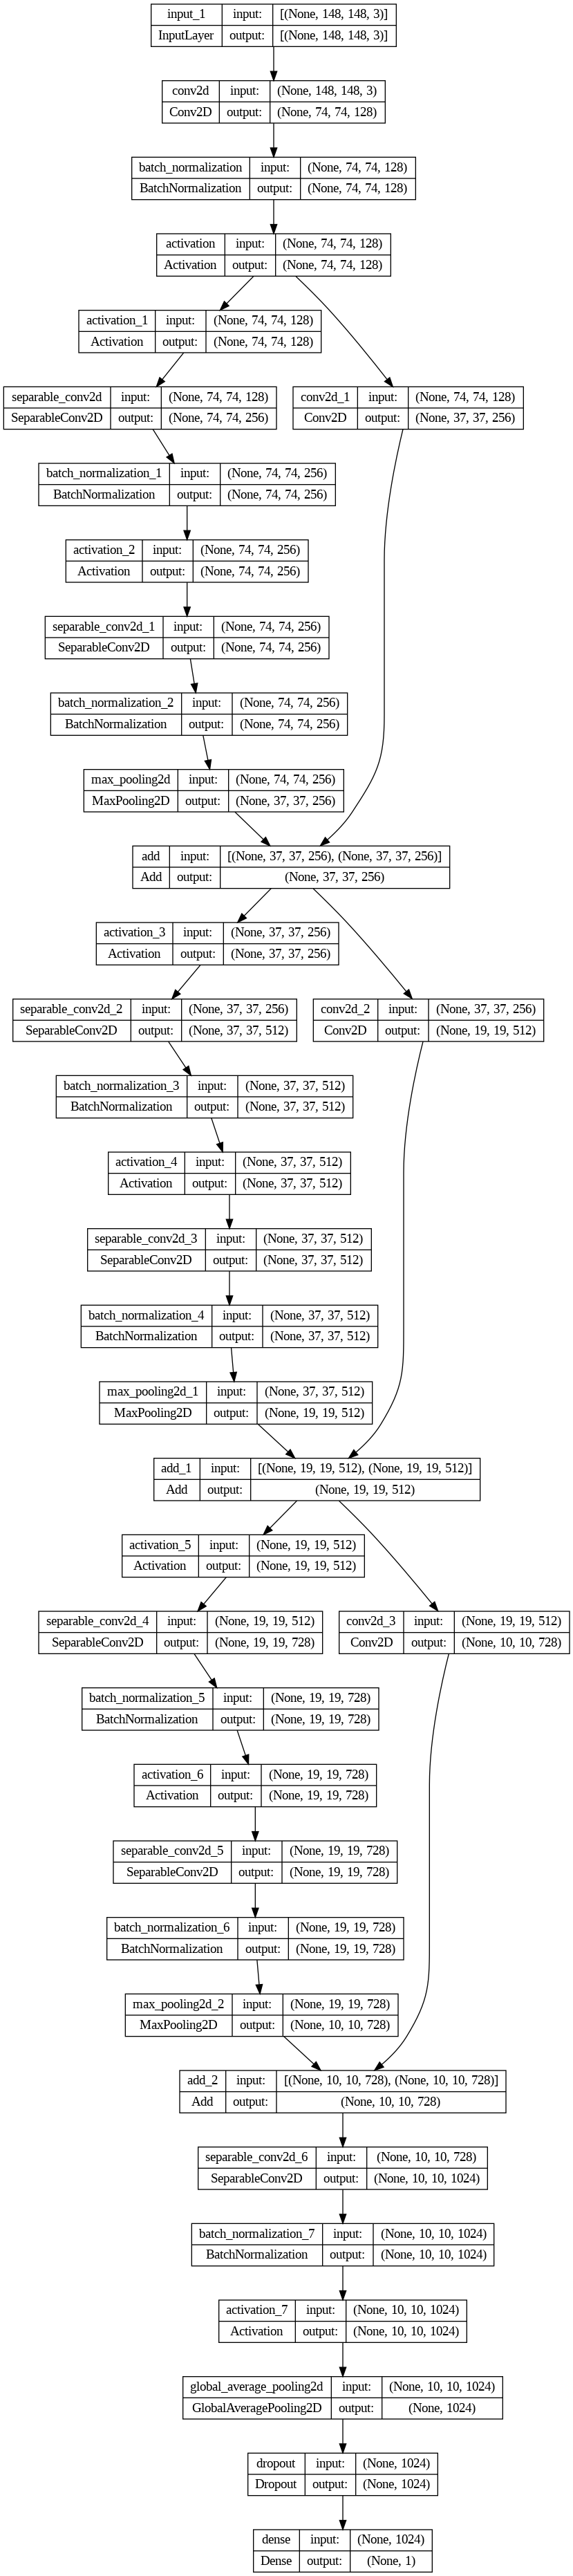

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

keras.utils.plot_model(model, show_shapes=True)

### Model Training

The model was trained on the training data using the model.fit function for 25 epochs. The training data was provided by the train_generator, and the number of steps per epoch was determined based on the total number of training samples divided by the batch size. Similarly, the validation data was supplied through val_generator, and the number of steps for validation was calculated based on the total number of validation samples divided by the batch size. This allowed for monitoring the model's performance on both the training and validation sets throughout the training process, providing insights into potential overfitting or underfitting. The training process aimed to minimize the binary cross-entropy loss and optimize the model's accuracy.

After the 6th epoch, the accuracy starts to decrease, so we will go with 6 epochs.

In [ ]:
# Training
epochs = 6
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size)

Epoch 1/6
206/206 [==============================] - 2557s 12s/step - loss: 0.6508 - accuracy: 0.6424 - val_loss: 0.6937 - val_accuracy: 0.4878
Epoch 2/6
206/206 [==============================] - 148s 718ms/step - loss: 0.5695 - accuracy: 0.7070 - val_loss: 0.7262 - val_accuracy: 0.5122
Epoch 3/6
206/206 [==============================] - 148s 714ms/step - loss: 0.5366 - accuracy: 0.7313 - val_loss: 0.5604 - val_accuracy: 0.7330
Epoch 4/6
206/206 [==============================] - 146s 708ms/step - loss: 0.5111 - accuracy: 0.7468 - val_loss: 0.4501 - val_accuracy: 0.7935
Epoch 5/6
206/206 [==============================] - 143s 693ms/step - loss: 0.4993 - accuracy: 0.7575 - val_loss: 0.9918 - val_accuracy: 0.6094
Epoch 6/6
206/206 [==============================] - 142s 686ms/step - loss: 0.4899 - accuracy: 0.7630 - val_loss: 0.4149 - val_accuracy: 0.8152


### Evaluation

### Classification Report

After the model was trained, it was evaluated on the validation set using the model.evaluate function. This process involved computing the loss and accuracy of the model's predictions on the validation data provided by val_generator. The evaluation was done in a verbose mode to show the progress. The calculated validation loss and accuracy were then printed to assess the model's performance on unseen data. The validation loss represented the binary cross-entropy loss, while the validation accuracy indicated the proportion of correct predictions made by the model on the validation set.

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

24/24 [==============================] - 7s 283ms/step - loss: 0.4150 - accuracy: 0.8159
Validation Loss: 0.4150
Validation Accuracy: 0.8159


After obtaining the ground truth labels for the validation data from val_generator.classes, the model's predictions were made on the validation data using model.predict(val_generator). To convert these predictions to binary labels (0 or 1), the probabilities were rounded using np.round(val_predictions). The predicted labels were then flattened to a 1D array using .flatten().

The model's performance on the validation set was further analyzed using a classification report and a confusion matrix. The classification report provided valuable metrics such as precision, recall, and F1-score for each class (0 and 1). This report helped evaluate the model's ability to correctly classify both classes. The confusion matrix displayed the number of true positives, true negatives, false positives, and false negatives, which allowed a more detailed assessment of the model's performance on individual classes.

In [ ]:
# Get the ground truth labels for the validation data
val_true_labels = val_generator.classes

# Make predictions on the validation data
val_predictions = model.predict(val_generator)

# Convert predictions to binary labels (0 or 1)
val_pred_labels = np.round(val_predictions).flatten()

# Classification Report and Confusion Matrix
print('')
print('Classification Report')
print('')
print(classification_report(val_true_labels, val_pred_labels))

24/24 [==============================] - 5s 209ms/step

Classification Report

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       754
           1       0.81      0.83      0.82       756

    accuracy                           0.82      1510
   macro avg       0.82      0.82      0.82      1510
weighted avg       0.82      0.82      0.82      1510



###  Confusion Matrix

After computing the confusion matrix using confusion_matrix(val_true_labels, val_pred_labels), the results were plotted using ConfusionMatrixDisplay from sklearn.metrics. The display labels were set to ['Poor Roads', 'Good Roads'] to represent the classes. The plot was generated using disp.plot(cmap='viridis', values_format='d'), with a color map of 'viridis' for better visualization. The values were formatted as integers using values_format='d'. The resulting confusion matrix plot provided a visual representation of the model's performance, highlighting the true positives, true negatives, false positives, and false negatives for each class, enabling a better understanding of the model's classification accuracy.

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)

# Plot the confusion matrix
classes = ['Poor Roads', 'Good Roads']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

### Training And Validation Loss Graph

The training history was accessed using history.history['loss'] and history.history['val_loss'] to retrieve the training and validation loss values for each epoch. The number of epochs was obtained using range(1, len(train_loss) + 1). A line plot was created to visualize the training and validation loss over the epochs using plt.plot(epochs, train_loss, label='Training Loss', marker='o') and plt.plot(epochs, val_loss, label='Validation Loss', marker='o'). The x-axis represents the epochs, while the y-axis represents the loss values. The plot was displayed with a legend, axis labels, and a title using appropriate plt functions. This visualization provides insights into the training process and helps identify potential overfitting or underfitting of the model during training.

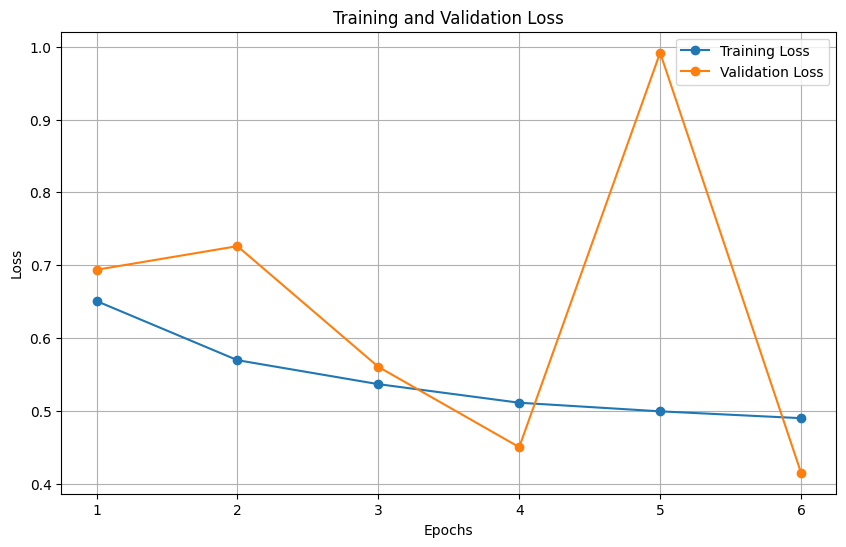

In [ ]:
import matplotlib.pyplot as plt

# Access training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

###  Training and Validation Accuracy Graph

The training history was accessed using history.history['accuracy'] and history.history['val_accuracy'] to retrieve the training and validation accuracy values for each epoch. The number of epochs was obtained using range(1, len(train_accuracy) + 1). A line plot was created to visualize the training and validation accuracy over the epochs using plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o') and plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o'). The x-axis represents the epochs, while the y-axis represents the accuracy values. The plot was displayed with a legend, axis labels, and a title using appropriate plt functions. This visualization provides insights into the model's training performance and helps assess how well the model generalizes to unseen data.

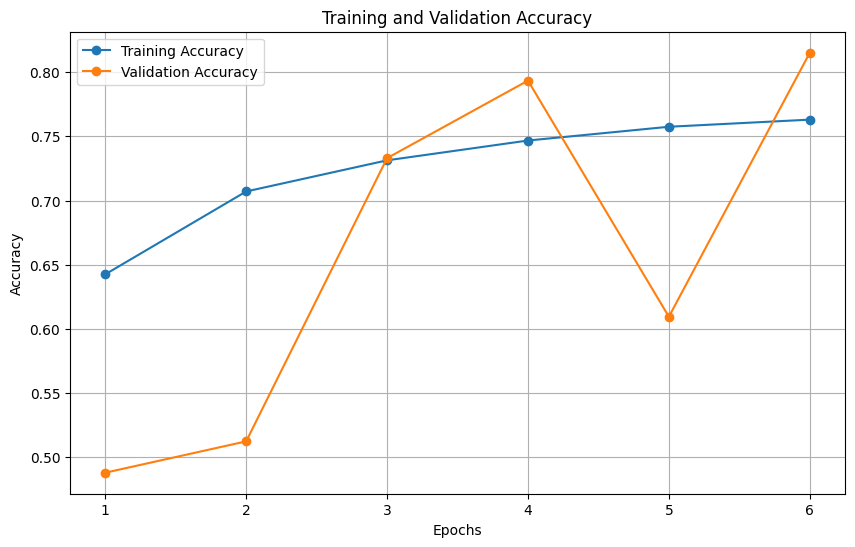

In [ ]:
# Access training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Saving the Model

In [ ]:
import joblib

# Save the model as a .pkl file
joblib.dump(model, 'model.pkl')

['model.pkl']

### Loading the Saved Model

In [ ]:
# Load the model from the .pkl file
loaded_model = joblib.load('model.pkl')